In [1]:
# Much of this comes from the site https://www.ethanrosenthal.com/2017/06/20/matrix-factorization-in-pytorch/
# Accessed on March 7th, 2021
"""
WARNING: It is quite possible to run out of RAM while running this notebook. 
If you have less than 16GB (preferably at least 24-32GB) then do not run.
"""

import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import os

from pathlib import Path

In [2]:
#%%
# If using colab
# from google.colab import drive
# drive.mount('/content/drive')
# DRIVE_PATH = "/content/drive/Shared drives/CMPUT466 Project"

# If using windows
DRIVE_PATH = Path("G:/Shared drives/CMPUT466 Project")

DATA_FOLDER=DRIVE_PATH/"src/data/"

# Read in the different data files
train = pd.read_csv(DATA_FOLDER/"user_data_train.csv")
validation = pd.read_csv(DATA_FOLDER/"user_data_validation.csv")
test = pd.read_csv(DATA_FOLDER/"user_data_test.csv")

# Concatenate them, since we need to reshape the dataset for this task.
data = pd.concat([train, validation, test])
data.head()

# Check the shape
print(data.shape)

(189777, 6)


In [3]:
# Converts any type of column into a categorical column,
# assigning each distinct item a unique numeric id.
def to_categorical(df, col):
    keys = df[col].unique()
    d = {key: i for i, key in enumerate(keys)}
    return np.array([d[key] for key in df[col]])

# Converts the dataframe into a matrix M, where M_i, j is the rating for the i'th user, j'th item. 
# If the rating was not specified, we assign it to be 0.
def get_sparse_matrix(df, usr_col, item_col, rating_col):
    return df.pivot_table(index=usr_col, columns=item_col, values=rating_col).fillna(0).astype(int)

# Convert the textual attributes we will use to categorical.
data["Title-Platform"] = data["Title"] + data["Platform"]
data["Username"] = to_categorical(data, "Username")
data["Title-Platform"] = to_categorical(data, "Title-Platform")

# Create the sparse matrix.
ratings = get_sparse_matrix(data, "Username", "Title-Platform", "Userscore").to_numpy()

In [4]:
"""
This is the general form of the dataset split that we will use in this case.
 ----------------a2-----
 |               |     |
 |               |     |
 |    Train      | Val | <- ratings
 |               |     |
 |               |     |
a1---------------|-----|
 |      Val      |Test |
 -----------------------
"""

def train_val_test_split(data, val_percent, test_percent):
    # Set a1, a2 to be 90% along their respective axes.
    a1 = data.shape[0] * 0.9 // 1
    a2 = data.shape[1] * 0.9 // 1
    
    # Get the indices of the specific areas in the sparse matrix.
    train_indices = np.mgrid[0:a1, 0:a2].reshape(2, -1).T
    val_indices_1 = np.mgrid[0:a1, a2:data.shape[1]].reshape(2, -1).T
    val_indices_2 = np.mgrid[a1:data.shape[0], 0:a2].reshape(2, -1).T
    val_indices = np.append(val_indices_1, val_indices_2, axis=0)
    test_indices = np.mgrid[a1:data.shape[0], a2:data.shape[1]].reshape(2, -1).T
    
    # Print the shapes to check and make sure they are correct.
    print(train_indices.shape, val_indices.shape, test_indices.shape)
    return train_indices, val_indices, test_indices 

train_indices, val_indices, test_indices = train_val_test_split(ratings, 0.05, 0.05)

# Print the percentage of data in each class.
print(f"Validation percentage: {val_indices.shape[0]/np.prod(data.shape)}")
print(f"Test percentage: {test_indices.shape[0]/np.prod(data.shape)}")

(110005160, 2) (24464628, 2) (1360204, 2)
Validation percentage: 18.41607179554349
Test percentage: 1.023911523223874


In [5]:
""" This model is based on Nguyenj et. al's work here: https://arxiv.org/pdf/1812.01478v1.pdf """

class DMF(nn.Module):
    def init_weights(self, layer):
        nn.init.xavier_uniform_(layer.weight)
        
    def __init__(self, n_users, n_items, n_factors=128):
        super().__init__() 
        # Define the NN for user vectors
        self.user_fc1 = nn.Linear(n_items, 1024).cuda() # The array of users will be (BATCH_SIZE x n_items)
        self.init_weights(self.user_fc1)
        self.user_fc2 = nn.Linear(1024, 512).cuda()
        self.init_weights(self.user_fc2)
        self.user_fc3 = nn.Linear(512, n_factors).cuda()
        self.init_weights(self.user_fc3)
        
        # Define the NN for item vectors
        self.item_fc1 = nn.Linear(n_users, 1024).cuda() # The array of items will be (BATCH_SIZE x n_users)
        self.init_weights(self.item_fc1)
        self.item_fc2 = nn.Linear(1024, 512).cuda()
        self.init_weights(self.item_fc2)
        self.item_fc3 = nn.Linear(512, n_factors).cuda()
        self.init_weights(self.item_fc3)
        
        # Similarity function to compare the latent features.
        self.sim = nn.CosineSimilarity()
                
    def forward(self, users, items):
        # Users network
        users = F.relu(self.user_fc1(users))
        users = F.relu(self.user_fc2(users))
        users = self.user_fc3(users)
        
        # Items network
        items = F.relu(self.item_fc1(items))
        items = F.relu(self.item_fc2(items))
        items = self.item_fc3(items)

        # Cosine similarity
        res = self.sim(users, items)
        return torch.add(torch.mul(res, 5), 5) # Map from [-1, 1] to [0, 10]
            
# Allows us to get a specified mixing of positive (non-zero) and negative (zero) samples. (i.e. 1:5)
def get_pos_neg_samples(data, idxs, neg_ratio):
    pos = data[idxs[:,0], idxs[:,1]].nonzero()[0]
    neg = (~data[idxs[:,0], idxs[:,1]].astype(bool)).nonzero()[0]
    base = len(pos)
    p = np.random.choice(len(neg), base*neg_ratio)
    return np.append(idxs[pos], idxs[p], axis=0)

""" 
NCE Loss from Xue et. al's paper here: https://www.ijcai.org/Proceedings/2017/0447.pdf
Not used in this model as we are comparing models based on RMSE.
"""
def NCE_Loss(outputs, targets):
    max_rating = 10
    outputs = torch.maximum(outputs, torch.Tensor([1e-5]).cuda())
    targets = torch.div(targets, max_rating)
    
    pos = torch.mul(targets, torch.log(outputs))
    neg = torch.mul(1 - targets, torch.log(1 - outputs))
    return -torch.sum(torch.add(pos, neg))
    
# Create the model
model = DMF(*ratings.shape)

100%|██████████| 4984/4984 [04:13<00:00, 19.67it/s]


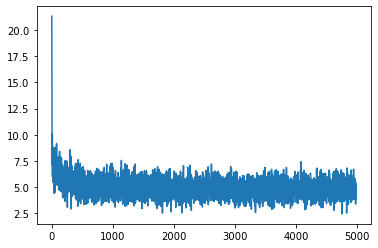

100%|██████████| 4984/4984 [04:15<00:00, 19.53it/s]


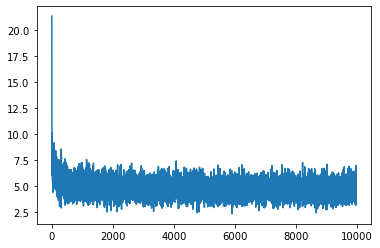

In [7]:
# Some hyperparameters.
BATCH_SIZE=256
EPOCHS = 2

def MBGD(model, data, idxs, neg_ratio=5):
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # learning rate
    idxs = get_pos_neg_samples(data, idxs, neg_ratio)
    data = torch.FloatTensor(data).cuda()
    l = [] # Array to keep track of losses, not done automatically.
    
    for epoch in range(EPOCHS):
        idxs = np.random.permutation(idxs) # Permute the ordering of the datapoints.
        for i in tqdm(range(0, idxs.shape[0], BATCH_SIZE)):
            batch_idxs = idxs[i:i+BATCH_SIZE]
            row_idxs, col_idxs = batch_idxs[:,0], batch_idxs[:,1]
            rows = data[row_idxs,:]
            cols = data[:,col_idxs].T
        
            # Set gradients to zero
            optimizer.zero_grad()

            # Get the actual ratings
            rating = data[row_idxs, col_idxs]

            # Predict and calculate loss
            prediction = model(rows, cols)

            loss = loss_func(prediction, rating)

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()
            l.append(loss)
        
        # Plot the loss after each epoch
        plt.plot(l[:-1])
        plt.show()
       
# Train the model
MBGD(model, ratings, train_indices.astype(np.int32))

In [ ]:
def test(model, data, idxs, sample=5000):
    with torch.no_grad():
        # Get all non-zero samples to check against ratings
        pos = data[idxs[:,0], idxs[:,1]].nonzero()[0]
        data = torch.Tensor(data)
        samples = np.random.choice(len(pos), sample)
        row_idxs = idxs[pos,0]
        col_idxs = idxs[pos,1]
        rows = torch.FloatTensor(data[row_idxs,:]).cuda()
        cols = torch.FloatTensor(data[:,col_idxs]).T.cuda()
        
        # Get the mean of the dataset
        mean = data[row_idxs,col_idxs].mean()
        print("Baseline score:", np.sqrt(((data[row_idxs,col_idxs] - mean)**2).sum() / len(row_idxs)))
        print("Model score:", np.sqrt(((data[row_idxs,col_idxs] - model(rows,cols).cpu()*10))**2).sum().cpu() / len(row_idxs))
        
        # Plot the distribution of the predicted ratings.
        sns.histplot(np.array(model(rows, cols).cpu()))    
        plt.show()
        
        # Plot the distribution of the actual ratings
        sns.histplot(data[row_idxs, col_idxs].cpu())
        plt.show()


test(model, ratings, val_indices.astype(np.int32))